# Forecasting GDP Time Series

Author: Arash Maskooki

##### Introduction:

The objective of this analysis is to predict GDP of United States using different forecasting methods. Specially, more attention is given to developing an ARIMA model for GDP as the best model in terms of RMSE. 
Models considered are as follows:

* Naive forecast
* Moving Average
* Single Exponential Smoothing
* Double Exponential Smoothing
* ARIMA


In [1]:
import pandas_datareader.data as dr
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fx import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

Getting historical data from online source,

In [2]:
gdp = dr.DataReader('GDP', 'fred')

Applying naive forecast, moving average with 3 and 5 window lengths, single and double exponential smoothing.

Implementation of these functions are in auxiliary function file 'fx.py'

In [3]:
nv = gdp.iloc[0]
ma3 = gdp.iloc[0]
ma5 = gdp.iloc[0]
es = gdp.iloc[0]
for i in range(1,len(gdp)+1):
    nv = nv.append(naive(gdp.iloc[:i]),ignore_index=True)
    ma3 = ma3.append(moving_avg(gdp.iloc[:i], 3),ignore_index=True)
    ma5 = ma5.append(moving_avg(gdp.iloc[:i], 5),ignore_index=True)
    es = es.append(expo_smooth(gdp.iloc[:i], .7),ignore_index=True)
des = double_expo_smooth(gdp, .98, .98)
des = pd.Series(data=des)

Now we forecast GDP for one step ahead in the future where historical data is still not available,

In [4]:
forecastDate = gdp.index[-1] + datetime.timedelta(days=3*31-1)

In [5]:
nv.index = gdp.index.insert(len(gdp),forecastDate)
ma3.index = gdp.index.insert(len(gdp),forecastDate)
ma5.index = gdp.index.insert(len(gdp),forecastDate)
es.index = gdp.index.insert(len(gdp),forecastDate)
des.index = gdp.index.insert(len(gdp),forecastDate)

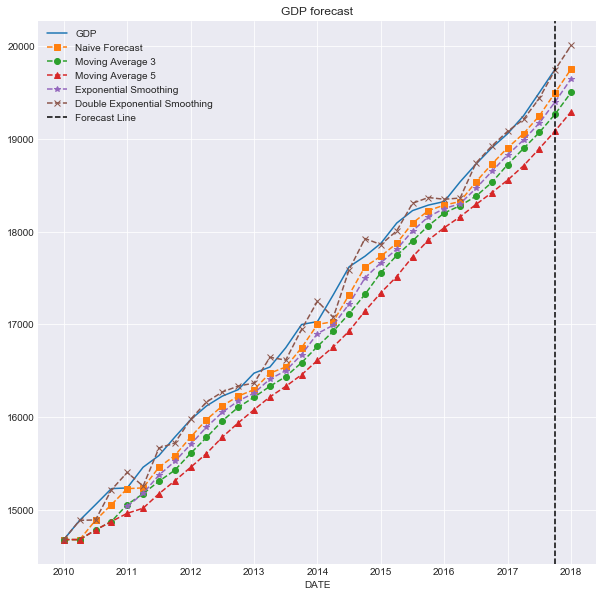

In [6]:
plt.figure()
sns.set_style("darkgrid")
gdp.plot(figsize=(10,10))
nv.plot(style='s--')
ma3.plot(style='o--')
ma5.plot(style='^--')
es.iloc[4:].plot(style='*--')
des.plot(style='x--')

plt.axvline(x=gdp.index[-1], color='k', linestyle='--')

plt.legend(['GDP','Naive Forecast','Moving Average 3',
            'Moving Average 5', 'Exponential Smoothing',
            'Double Exponential Smoothing','Forecast Line'])
plt.title('GDP forecast');

In [7]:
L = len(gdp.iloc[1:])
nv_rmse = np.sqrt((gdp.iloc[1:].subtract(nv[1:-1], axis=0)**2).sum()/L).values
ma3_rmse = np.sqrt((gdp.iloc[1:].subtract(ma3[1:-1], axis=0)**2).sum()/L).values
ma5_rmse = np.sqrt((gdp.iloc[1:].subtract(ma5[1:-1], axis=0)**2).sum()/L).values
es_rmse = np.sqrt((gdp.iloc[1:].subtract(es[1:-1], axis=0)**2).sum()/L).values
des_rmse = np.sqrt((gdp.iloc[1:].subtract(des[1:-1], axis=0)**2).sum()/L).values

In [8]:
print('RMSE Error for:')
print('1. Naive Forecast: {}'.format(nv_rmse[0])); 
print('2. Moving average (3): {}'.format(ma3_rmse[0])); 
print('3. Moving average (5): {}'.format(ma5_rmse[0])) ;
print('4. Exponential Smoothing: {}'.format(es_rmse[0])) ;
print('4. Double Exponential Smoothing: {}'.format(des_rmse[0])) ;

RMSE Error for:
1. Naive Forecast: 179.66148204932867
2. Moving average (3): 327.06195073915535
3. Moving average (5): 468.3980254575388
4. Exponential Smoothing: 912.1061944599035
4. Double Exponential Smoothing: 107.51422875560671


Based on RMSE criterion Double Exponential Smoothing has the best performance among the above methods.

Now we try ARIMA model.

## ARIMA model

In [9]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

The series is clearly non-stationary; It has a trend and the mean is not constant. Hence we differentiate it to make it stationary,

Text(0.5,1,'Differentiated GDP')

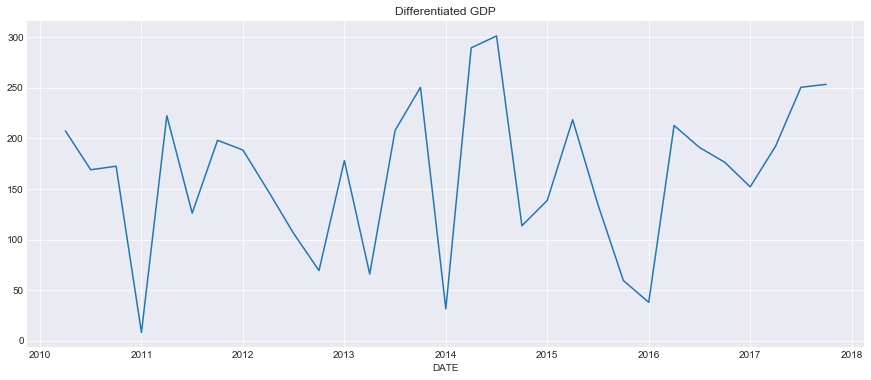

In [21]:
dgdp = gdp.diff()[1:]
dgdp = pd.Series(dgdp['GDP'])
plt.figure()
dgdp.plot()
plt.title('Differentiated GDP')

Dividing data into training set and test set,

In [22]:
n_train_test = 27
dgdp_train = dgdp[:n_train_test]
dgdp_test = dgdp[n_train_test:]

predic_index = dgdp_test.index
predic_index

DatetimeIndex(['2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01'], dtype='datetime64[ns]', name='DATE', freq=None)

Adding prediction dates beyond historical data,

In [23]:
interval = predic_index[-1]-predic_index[-2]
predic_index = predic_index.append(pd.DatetimeIndex([predic_index[-1] + i * interval for i in range(1,5)]))
predic_index

DatetimeIndex(['2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01',
               '2018-01-01', '2018-04-03', '2018-07-04', '2018-10-04'],
              dtype='datetime64[ns]', freq=None)

To check if the differe ntiated signal is stationary and also determine the order of ARIMA model we plot ACF and PACF,

In [24]:
n_lags = min([len(dgdp_train)-1,30])
lag_acf = acf(dgdp_train, nlags=n_lags)
lag_pacf = pacf(dgdp_train, nlags=n_lags, method='ols')

Text(0.5,1,'Autocorrelation Function')

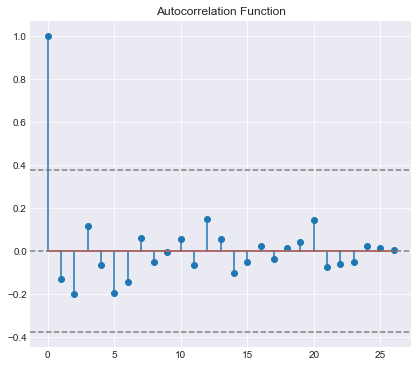

In [25]:
#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dgdp_train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dgdp_train)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

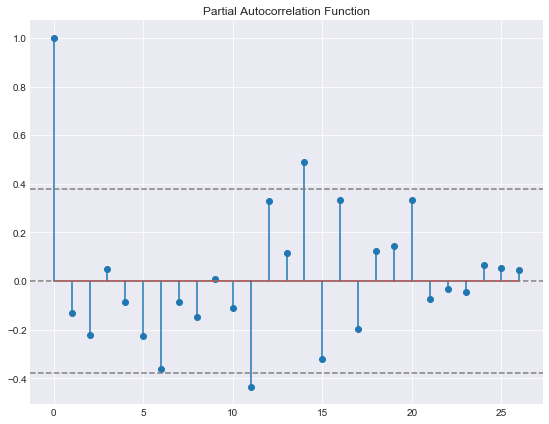

In [26]:
#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dgdp_train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dgdp_train)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

There is no sign of non-stationarity in ACF and PACF plots, to test this hypothesis we perform unit root test (Dickey-Fuller)

In [27]:
from statsmodels.tsa.stattools import adfuller

In [28]:
#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(dgdp_train, autolag='AIC')
print(dftest)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Results of Dickey-Fuller Test:
(-2.8873626229136806, 0.04683741183900975, 5, 21, {'1%': -3.7883858816542486, '5%': -3.013097747543462, '10%': -2.6463967573696143}, 200.71637887616652)
Test Statistic                 -2.887363
p-value                         0.046837
#Lags Used                      5.000000
Number of Observations Used    21.000000
dtype: float64


The test confirms that the process is stationary. Next, we fit the model to training data, 

In [35]:
model = ARIMA(dgdp_train, order=(11, 0, 0)) 
results_AR = model.fit(disp=-1) 
predicted = results_AR.predict(start=predic_index[0], end=predic_index[-1])
dgdp_fitted = results_AR.fittedvalues.append(predicted)


                              ARMA Model Results                              
Dep. Variable:                    GDP   No. Observations:                   27
Model:                    ARMA(11, 0)   Log Likelihood                -167.878
Method:                       css-mle   S.D. of innovations             68.077
Date:                Wed, 25 Apr 2018   AIC                            361.756
Time:                        09:23:05   BIC                            378.602
Sample:                    04-01-2010   HQIC                           366.765
                         - 10-01-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        161.2581        nan        nan        nan         nan         nan
ar.L1.GDP     -0.3722   1.13e-05  -3.28e+04      0.000      -0.372      -0.372
ar.L2.GDP     -0.4410   1.41e-05  -3.12e+04      0.0

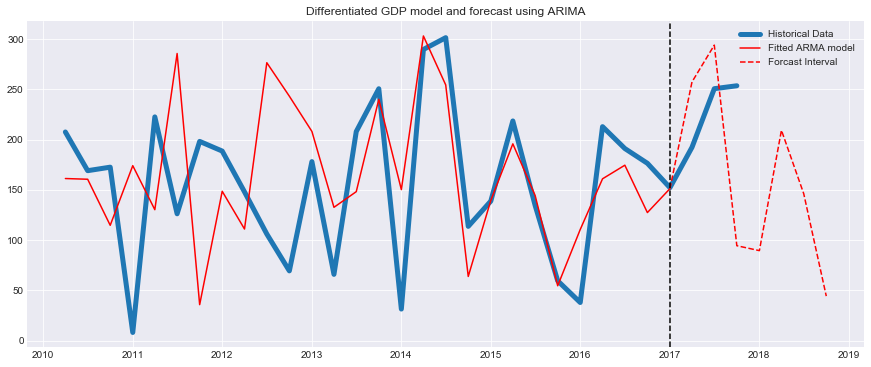

In [45]:
print(results_AR.summary())
plt.plot(dgdp, linewidth=5)
plt.plot(dgdp_fitted[:n_train_test+1], color='red')
plt.plot(dgdp_fitted[n_train_test:], color='red', linestyle='--')
plt.axvline(x=predic_index[0], color='k', linestyle='--')
plt.title('Differentiated GDP model and forecast using ARIMA')
plt.legend(['Historical Data','Fitted ARMA model','Forcast Interval'])
plt.show()

To obtain GDP we have to integrate 'dgdp' variable and add the base value GDP

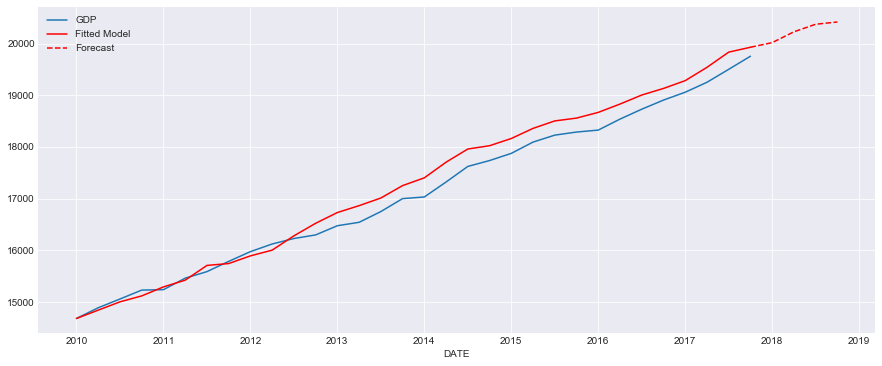

In [39]:

gdp_predict = dgdp_fitted.cumsum() + gdp['GDP'][0]
gdp_predict = pd.concat([gdp['GDP'][0:1],gdp_predict])
plt.figure()
gdp['GDP'].plot()
gdp_predict[:len(gdp)].plot(style='r')
gdp_predict[len(gdp)-1:].plot(style='r--')

plt.legend(['GDP','Fitted Model','Forecast'])

In [44]:
gdps = gdp.GDP
ARIMA_RMSE = np.sqrt(sum((gdp_predict[dgdp_test.index]-gdps[dgdp_test.index])**2)/len(results_AR.fittedvalues))
print('ARIMA RMSE: {:.4}'.format(ARIMA_RMSE))

ARIMA RMSE: 100.8


Hence ARIMA model has slightly better RMSE performance (~7%) than double exponential smoothing